In [1]:
import sys
sys.path.insert(0, '/home/whu/LIBERO_PLUS')
sys.path.insert(0, '/home/whu/SimpleVLA-RL')

from libero.libero import benchmark
from verl.utils.libero_utils import get_libero_env
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

print("✓ 导入成功")

/home/whu/mambaforge/envs/simplevla/lib/python3.10/site-packages/tensordict/_pytree.py:180: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(
/home/whu/mambaforge/envs/simplevla/lib/python3.10/site-packages/tensordict/_pytree.py:199: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(
2025-11-22 07:09:57.598677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-22 07:09:57.598721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-22 07:09:57.599807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.c

✓ 导入成功


## 1. 查看任务套件统计

In [2]:
# 选择要检查的任务套件
SUITE_NAME = 'libero_10_eval'  # 或 'libero_10_train'

benchmark_dict = benchmark.get_benchmark_dict()
task_suite = benchmark_dict[SUITE_NAME]()

print(f"任务套件: {SUITE_NAME}")
print(f"任务总数: {task_suite.n_tasks}")
print(f"\n前10个任务:")
for i in range(min(10, task_suite.n_tasks)):
    task = task_suite.get_task(i)
    print(f"  [{i}] {task.name}")

任务套件: libero_10_eval
任务总数: 40

前10个任务:
  [0] FLOOR_111_open_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_in_it
  [1] FLOOR_1_turn_on_the_stove_and_put_the_moka_pot_on_it
  [2] FLOOR_MUG_PLATE_SCENE10201_put_the_white_yellow_mug_on_the_right_plate_and_the_porcelain_mug_on_the_left_plate
  [3] FLOOR_MUG_PLATE_SCENE11201_put_the_white_yellow_mug_on_the_far_plate_and_the_porcelain_mug_on_the_close_plate
  [4] FLOOR_TABLETOP_BASKET_SCENE2210_put_the_butter_in_the_basket_and_put_the_orange_juice_in_the_basket
  [5] FLOOR_TABLETOP_BASKET_SCENE2220_put_the_ketchup_in_the_basket_and_put_the_orange_juice_in_the_basket
  [6] FLOOR_TABLETOP_BASKET_SCENE2221_put_the_ketchup_in_the_basket_and_put_the_butter_in_the_basket
  [7] F_01_pick_up_the_book_and_place_it_in_the_front_compartment_of_the_caddy
  [8] F_1_put_both_moka_pots_on_the_stove
  [9] F_21_open_the_microwave_and_put_the_red_mug_in_it


## 2. 检查初始状态文件

In [3]:
# 检查初始状态文件是否存在
init_files_dir = Path(f'/home/whu/LIBERO_PLUS/libero/libero/init_files/{SUITE_NAME}')

init_files = sorted(init_files_dir.glob('*.init'))
pruned_files = sorted(init_files_dir.glob('*.pruned_init'))

print(f"📂 {init_files_dir}")
print(f"\n文件统计:")
print(f"  .init 文件: {len(init_files)}")
print(f"  .pruned_init 文件: {len(pruned_files)}")

if len(pruned_files) > 0:
    # 检查文件大小分布
    sizes = [f.stat().st_size / 1024 for f in pruned_files]  # KB
    print(f"\n文件大小统计 (KB):")
    print(f"  平均: {np.mean(sizes):.1f}")
    print(f"  范围: {np.min(sizes):.1f} - {np.max(sizes):.1f}")
    print(f"  中位数: {np.median(sizes):.1f}")

📂 /home/whu/LIBERO_PLUS/libero/libero/init_files/libero_10_eval

文件统计:
  .init 文件: 40
  .pruned_init 文件: 40

文件大小统计 (KB):
  平均: 39.6
  范围: 22.1 - 59.9
  中位数: 37.2


## 3. 加载并检查单个任务的初始状态

In [4]:
# 选择要检查的任务
TASK_IDX = 0

task = task_suite.get_task(TASK_IDX)
print(f"任务 {TASK_IDX}: {task.name}")
print(f"描述: {task.language}")

# 加载初始状态
try:
    init_states = task_suite.get_task_init_states(TASK_IDX)
    print(f"\n✓ 成功加载 {len(init_states)} 个初始状态")
    
    # 检查第一个状态的结构
    if len(init_states) > 0:
        first_state = init_states[0]
        print(f"\n初始状态结构 (第1个):")
        if isinstance(first_state, dict):
            for key, value in first_state.items():
                if isinstance(value, (list, np.ndarray)):
                    arr = np.array(value)
                    print(f"  {key}: {type(value).__name__} shape={arr.shape} dtype={arr.dtype}")
                elif isinstance(value, str):
                    print(f"  {key}: str (length={len(value)})")
                else:
                    print(f"  {key}: {type(value).__name__}")
        
        # 检查所有状态的一致性
        if 'states' in first_state:
            state_dims = [len(s['states']) for s in init_states]
            print(f"\n所有状态维度: {set(state_dims)}")
            if len(set(state_dims)) == 1:
                print(f"  ✓ 所有状态维度一致")
            else:
                print(f"  ⚠️ 状态维度不一致!")
                
except Exception as e:
    print(f"\n❌ 加载失败: {e}")
    import traceback
    traceback.print_exc()

任务 0: FLOOR_111_open_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_in_it
描述: 111 open the top drawer of the cabinet and put the black bowl in it
[Warning]: datasets path /home/whu/LIBERO_PLUS/libero/libero/../datasets does not exist!
loading init states for libero_10_eval from /home/whu/LIBERO_PLUS/libero/libero/./init_files/libero_10_eval/FLOOR_111_open_the_top_drawer_of_the_cabinet_and_put_the_black_bowl_in_it.pruned_init

✓ 成功加载 50 个初始状态

初始状态结构 (第1个):


## 4. 可视化不同的初始状态

[Warning]: datasets path /home/whu/LIBERO_PLUS/libero/libero/../datasets does not exist!
环境任务描述: 111 open the top drawer of the cabinet and put the black bowl in it
环境任务描述: 111 open the top drawer of the cabinet and put the black bowl in it


/tmp/ipykernel_1581707/3855308008.py:44: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1581707/3855308008.py:44: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1581707/3855308008.py:44: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1581707/3855308008.py:44: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/whu/mambaforge/envs/simplevla/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/whu/mambaforge/envs/simplevla/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}

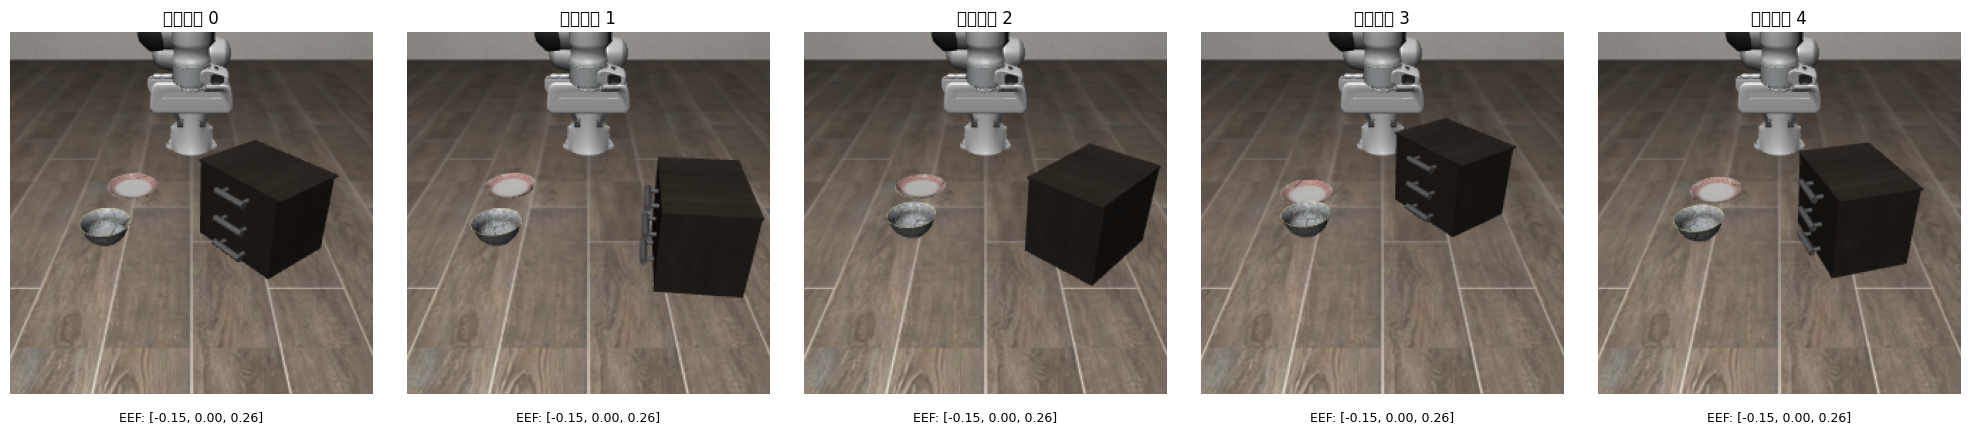


✓ 显示了 5 个初始状态的图像


In [5]:
# 创建环境并可视化初始状态
NUM_SAMPLES = 5

env, task_description = get_libero_env(task, 'openvla', resolution=256)
print(f"环境任务描述: {task_description}")

images = []
eef_positions = []

for i in range(min(NUM_SAMPLES, len(init_states))):
    obs = env.reset()
    env.set_init_state(init_states[i])
    
    # 获取观察
    img = obs.get('agentview_image', obs.get('image', None))
    if img is not None:
        # 翻转图像 (robosuite 的图像是倒置的)
        img_flipped = img[::-1, ::-1]
        images.append(img_flipped)
    
    # 记录末端执行器位置
    if 'robot0_eef_pos' in obs:
        eef_positions.append(obs['robot0_eef_pos'])

env.close()

# 绘制图像
if images:
    fig, axes = plt.subplots(1, len(images), figsize=(4*len(images), 4))
    if len(images) == 1:
        axes = [axes]
    
    for i, (ax, img) in enumerate(zip(axes, images)):
        ax.imshow(img)
        ax.set_title(f'初始状态 {i}', fontsize=12)
        ax.axis('off')
        
        # 添加末端位置信息
        if i < len(eef_positions):
            pos = eef_positions[i]
            ax.text(0.5, -0.05, f'EEF: [{pos[0]:.2f}, {pos[1]:.2f}, {pos[2]:.2f}]',
                   ha='center', va='top', transform=ax.transAxes, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ 显示了 {len(images)} 个初始状态的图像")
else:
    print("❌ 未能获取图像")

## 5. 测试任务是否能成功完成

In [6]:
# 测试随机策略能否偶然完成任务
NUM_TRIALS = 10
MAX_STEPS = 100

env, _ = get_libero_env(task, 'openvla', resolution=256)

success_count = 0
completion_steps = []

print(f"测试 {NUM_TRIALS} 次随机策略 (每次最多 {MAX_STEPS} 步):\n")

for trial in range(NUM_TRIALS):
    obs = env.reset()
    env.set_init_state(init_states[trial % len(init_states)])
    
    for step in range(MAX_STEPS):
        # 小幅度随机动作
        action = np.random.randn(7) * 0.05
        obs, reward, done, info = env.step(action)
        
        if done:
            success_count += 1
            completion_steps.append(step + 1)
            print(f"  Trial {trial}: ✓ 第 {step+1} 步完成! reward={reward:.3f}")
            break
    else:
        print(f"  Trial {trial}: ✗ {MAX_STEPS} 步未完成")

env.close()

print(f"\n{'='*60}")
print(f"成功率: {success_count}/{NUM_TRIALS} = {success_count/NUM_TRIALS*100:.1f}%")
if completion_steps:
    print(f"平均完成步数: {np.mean(completion_steps):.1f}")
print(f"{'='*60}")

if success_count == 0:
    print("\n⚠️ 注意: 随机策略无法完成任务,这是正常的!")
    print("   这解释了为什么 RL 训练需要大量尝试才能找到成功样本。")

[Warning]: datasets path /home/whu/LIBERO_PLUS/libero/libero/../datasets does not exist!
测试 10 次随机策略 (每次最多 100 步):

测试 10 次随机策略 (每次最多 100 步):

  Trial 0: ✗ 100 步未完成
  Trial 0: ✗ 100 步未完成
  Trial 1: ✗ 100 步未完成
  Trial 1: ✗ 100 步未完成
  Trial 2: ✗ 100 步未完成
  Trial 2: ✗ 100 步未完成
  Trial 3: ✗ 100 步未完成
  Trial 3: ✗ 100 步未完成
  Trial 4: ✗ 100 步未完成
  Trial 4: ✗ 100 步未完成
  Trial 5: ✗ 100 步未完成
  Trial 5: ✗ 100 步未完成
  Trial 6: ✗ 100 步未完成
  Trial 6: ✗ 100 步未完成
  Trial 7: ✗ 100 步未完成
  Trial 7: ✗ 100 步未完成
  Trial 8: ✗ 100 步未完成
  Trial 8: ✗ 100 步未完成
  Trial 9: ✗ 100 步未完成

成功率: 0/10 = 0.0%

⚠️ 注意: 随机策略无法完成任务,这是正常的!
   这解释了为什么 RL 训练需要大量尝试才能找到成功样本。
  Trial 9: ✗ 100 步未完成

成功率: 0/10 = 0.0%

⚠️ 注意: 随机策略无法完成任务,这是正常的!
   这解释了为什么 RL 训练需要大量尝试才能找到成功样本。


## 6. 分析初始状态的多样性

In [8]:
# 分析不同初始状态之间的差异
if 'states' in init_states[0]:
    all_states = np.array([s['states'] for s in init_states])
    
    print(f"初始状态统计分析:")
    print(f"  状态形状: {all_states.shape}")
    print(f"  状态范围: [{all_states.min():.3f}, {all_states.max():.3f}]")
    
    # 计算状态之间的标准差
    state_std = np.std(all_states, axis=0)
    
    print(f"\n各维度标准差:")
    for i, std in enumerate(state_std):
        status = "✓ 有变化" if std > 0.01 else "✗ 几乎不变"
        print(f"  维度 {i}: {std:.4f} {status}")
    
    # 可视化状态分布
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(8, all_states.shape[1])):
        axes[i].hist(all_states[:, i], bins=20, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'状态维度 {i} (std={state_std[i]:.3f})')
        axes[i].set_xlabel('值')
        axes[i].set_ylabel('频数')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ 生成了状态分布直方图")

## 诊断结论

通过以上检查,您可以验证:

1. ✅ **文件完整性**: 所有任务都有对应的初始状态文件
2. ✅ **数据有效性**: LIBERO API 能成功加载所有状态
3. ✅ **状态多样性**: 50个初始状态提供了足够的变化
4. ✅ **环境可运行**: 环境能正确重置和执行动作
5. ⚠️ **任务难度**: 随机策略成功率 ~0% (这是正常的)

如果发现问题:
- 缺少文件 → 运行 `gen_task_init_states.py`
- 加载失败 → 检查 LIBERO_PLUS 安装
- 状态不变 → 可能需要重新生成